In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

from gym import wrappers

from matplotlib import pyplot as plt

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2017-05-13 19:16:21,399] Making new env: MountainCar-v0


In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        state_feats = self.featurize_state(s)
        if a:
            return self.models[a].predict(state_feats.reshape(1,-1))
        else: 
            return np.array([self.models[a].predict(state_feats.reshape(1,-1)) for a in range(env.action_space.n)])
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        self.models[a].partial_fit([self.featurize_state(s)], [y])
        return None

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, SARSA = False):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
        SARSA: Whether or not to change learning to on-policy SARSA updates
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        state = env.reset()
        t = 0
        next_action = None
        while True:
            if SARSA:
                # Hackish but it works for now
                if next_action is None:
                    action_probs = policy(state)
                    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                else:
                    action = next_action
            else:
                action_probs = policy(state)
                action = np.random.choice(len(action_probs), p=action_probs)
            successor, reward, done, _ = env.step(action)
            stats.episode_lengths[i_episode] = t
            stats.episode_rewards[i_episode] += reward
            successor_Q = estimator.predict(successor)
            if SARSA:
                next_action_probs = policy(successor)
                next_action = np.random.choice(len(next_action_probs), p=next_action_probs)
                td_target = reward+discount_factor*successor_Q[next_action]
            else:
                td_target = reward+discount_factor*np.max(successor_Q)
            estimator.update(state, action, td_target)
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
            if done:
                break
            t += 1
            state = successor
    return stats

In [7]:
estimator = Estimator()

In [8]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = learning(env, estimator, 500, epsilon=0.0)

Step 86 @ Episode 500/500 (-174.0))

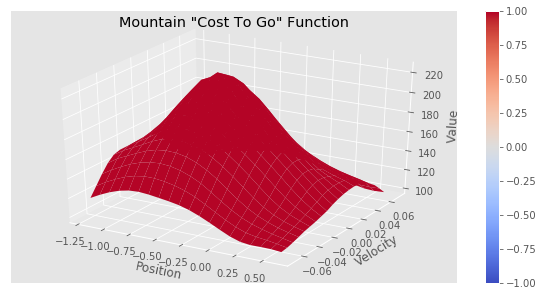

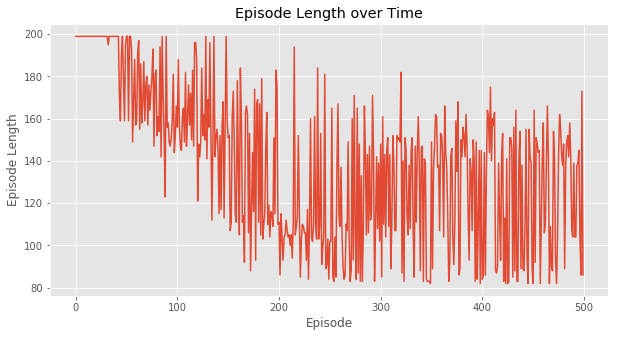

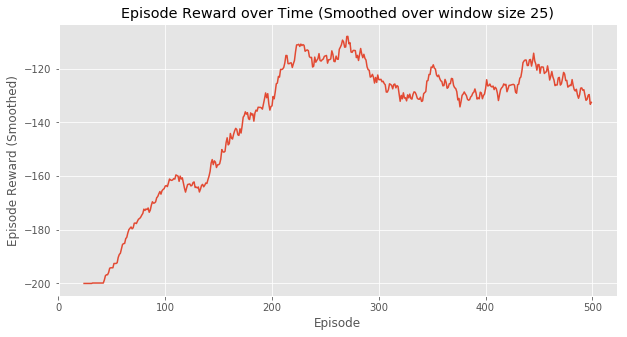

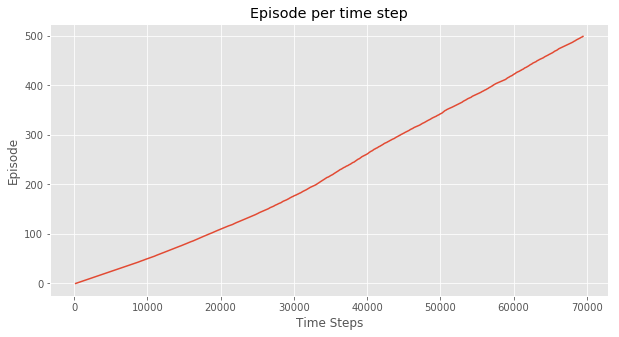

(<matplotlib.figure.Figure at 0x106315fd0>,
 <matplotlib.figure.Figure at 0x11160e7f0>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [10]:
estimatorSARSA = Estimator()

In [11]:
statsSARSA = learning(env, estimatorSARSA, 500, epsilon=0.0, SARSA = True)

Step 96 @ Episode 1/500 (0.0)

/Users/jasonmancuso/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Step 115 @ Episode 500/500 (-144.0)

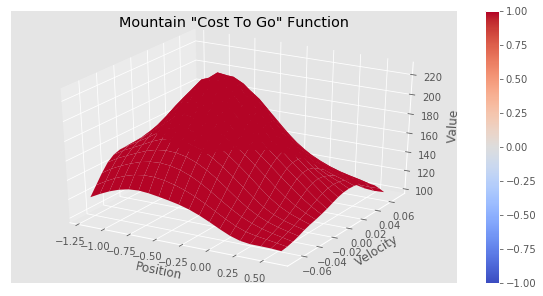

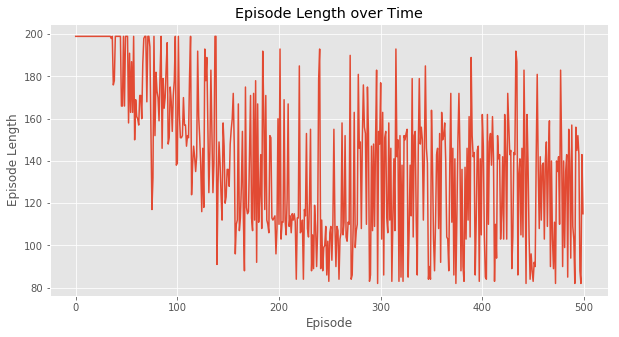

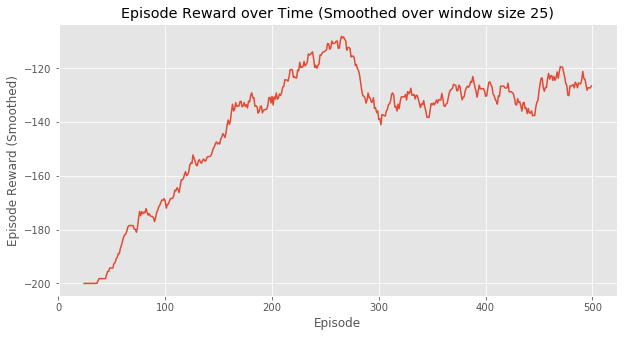

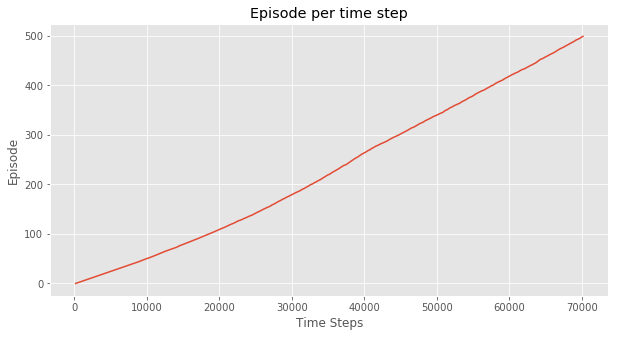

(<matplotlib.figure.Figure at 0x11140a860>,
 <matplotlib.figure.Figure at 0x111b1f438>)

In [12]:
plotting.plot_cost_to_go_mountain_car(env, estimatorSARSA)
plotting.plot_episode_stats(statsSARSA, smoothing_window=25)

In [ ]:
rec_estimator = Estimator()
env = wrappers.Monitor(env, 'mountaincar-experiment-Q-3')
rec_stats = learning(env, rec_estimator, 200, epsilon=0.0)
env.render(close=True)

In [ ]:
plotting.plot_cost_to_go_mountain_car(env, rec_estimator)
plotting.plot_episode_stats(rec_stats, smoothing_window=25)

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [9]:
def render_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, SARSA = False):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
        SARSA: Whether or not to change learning to on-policy SARSA updates
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    frames = []
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        state = env.reset()
        t = 0
        next_action = None
        while True:
            if SARSA:
                # Hackish but it works for now
                if next_action is None:
                    action_probs = policy(state)
                    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                else:
                    action = next_action
            else:
                action_probs = policy(state)
                action = np.random.choice(len(action_probs), p=action_probs)
            frames.append(env.render(mode = 'rgb_array'))
            successor, reward, done, _ = env.step(action)
            stats.episode_lengths[i_episode] = t
            stats.episode_rewards[i_episode] += reward
            successor_Q = estimator.predict(successor)
            if SARSA:
                next_action_probs = policy(successor)
                next_action = np.random.choice(len(next_action_probs), p=next_action_probs)
                td_target = reward+discount_factor*successor_Q[next_action]
            else:
                td_target = reward+discount_factor*np.max(successor_Q)
            estimator.update(state, action, td_target)
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
            if done:
                break
            t += 1
            state = successor
    env.render(close=True)
    return stats, frames

In [10]:
estimator = Estimator()

In [11]:
stats, frames = render_learning(env, estimator, 300, epsilon=0.0, SARSA=True)

Episode 1/300 (0.0)

/Users/jasonmancuso/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Step 126 @ Episode 300/300 (-109.0)

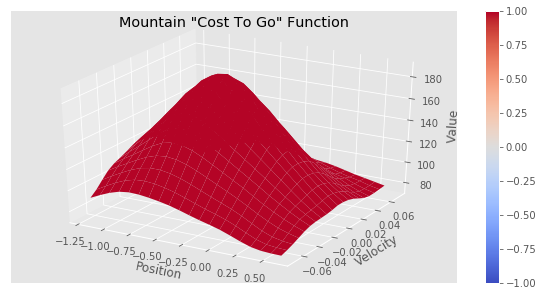

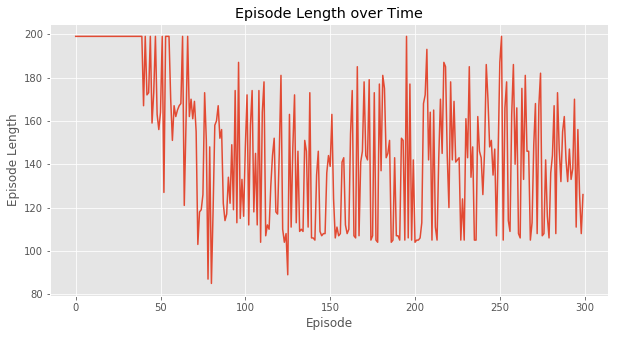

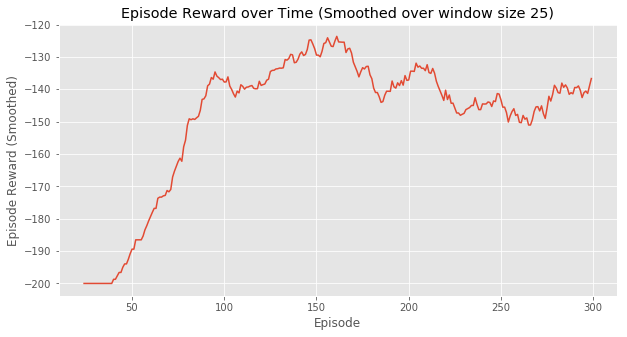

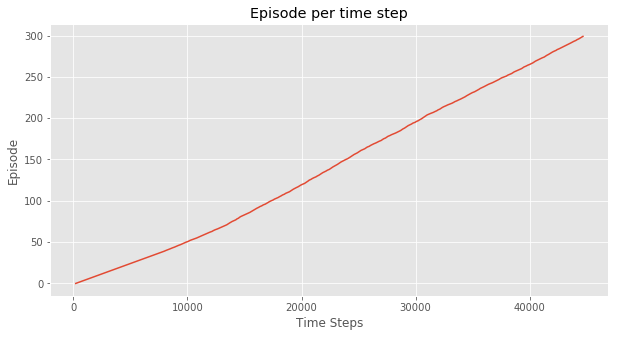

(<matplotlib.figure.Figure at 0x1239deef0>,
 <matplotlib.figure.Figure at 0x1106076a0>)

In [12]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [ ]:
display_frames_as_gif(frames)

Reinforcement learning is a field of machine learning concerned with algorithms that learn optimal play in game-theoretic settings.  The field has been responsible for a number of advancements in artificial intelligence, including AlphaGo's victory over the world champion Go player Lee Sedol.  Recent research has the potential to bring innovation to a variety of industries.  This talk will take you from reinforcement learning basics to state-of-the-art advances that combine reinforcement learning with deep learning.

Deep learning has recently allowed for surprising advancements in artificial intelligence. 
 Deep learning has allowed computers to achieve superhuman performance at a variety of tasks that were previously thought to be intractable.  Foremost among these achievements was Google DeepMind's AlphaGo, a Go-playing agent that beat world champion Lee Sedol using a strategy derived from deep reinforcement learning.  Reinforcement learning is a field of machine learning concerned with the theory of algorithms that learn optimal control, most often in game-theoretic settings.  It has a history of being applied in operations research, robotics, and game-playing, although the methods are general enough to be applied in a variety of settings.

### Agent-Environment Interaction
The main vehicle for reinforcement learning is the interaction of an agent with its environment.  The state is a compact representation of the world at a given moment in time.  The agent takes an action, and thereby interacts with its environment.  The environment takes in that action, and the agent then observes a reward and a new state according to some transition probabilities.  Together, the agent and environment form a feedback loop.  The environment can be deterministic or stochastic.
### Markov Decision Process
A Markov decision process is a mathematical abstraction based on the intuition of the agent-environment feedback loop.  It incorporates states, actions, rewards, and transition probabilities into a mathematical framework.  Formally, an MDP is a Markov chain augmented with actions and rewards to allow for goal-oriented decision-making.
### RL Agent Basics
We need to define a policy and a value function to give a mechanism for our agent's decision-making.  A policy, pi, is a distribution over actions given states.  A policy takes in our current state and outputs its recommended action.  A state-value function, v, represents the reward expected from following a certain policy from the current state.  Alternatively, we can define an action-value function, Q, in place of the state-value function.  The action-value function represents the reward expected from taking a certain action in the current state and following a certain policy thereafter.  The policy is derived from the current action-value function, and the value function is derived from the current policy.
### Q-Learning
In Q-Learning, we learn the optimal action-value function from the agent's experiences.  We differentiate between a behavior policy and a target policy.  We use the behavior policy to choose actions, but we use the target policy to update our Q function.  The behavior policy is epsilon-greedy, while the target policy is purely greedy.  The Q function values are stored in a dictionary and updated iteratively throughout the learning process.
### Function Approximation
There are often too many states or actions in our MDP to store all combinations in a dictionary.  For this reason, it's common to approximate the true action-value function.  This is identical to the classical supervised learning problem, where the features are generated from the state-action pairs and the labels are the expected rewards.  We use a linear model of those features to predict the action-value outputs, and then update based on the model's loss function.  This allows us to generalize to states that we haven't seen before, which was impossible in the original, table-lookup version of Q-learning.
### Deep Q-Learning
In Deep Q-Learning, we replace our linear function approximator with a deep neural network.    When using screen image data as our state representation, we use a convolutional neural network.  An additional feature called experience replay is necessary to make this setup work.  In practice, convergence on an optimal policy requires a few additional tweaks, including a decaying epsilon schedule and a secondary target network.

I listed this talk's audience as Intermediate mostly because I start with the basics, so anyone with some coursework in math can understand.  However, the material is pretty demanding, so I may need to change that to Experienced based on the committee's discretion.